In [1]:
from openfermion import *
import numpy as np
from pyquil import *
from pyquil.paulis import *
from scipy.optimize import *
from pyquil.api import WavefunctionSimulator, get_qc
from pyquil.api import *
from pyquil.gates import RY, CNOT, MEASURE, H
import openfermion as of
import openfermionpyscf as ofpyscf
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.environ["HOME"], "VQE")))
from qpus_and_qvms_copy import select_available_qpu

### Prepare Hamiltonian using OpenFermion

In [2]:
#this code is adapted from OpenFermion tutorials

# Set molecule parameters
def build_Hamiltonian(bondLen):
    
    geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, bondLen))]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    
    # Perform electronic structure calculations and
    # obtain Hamiltonian as an InteractionOperator
    hamiltonian = ofpyscf.generate_molecular_hamiltonian(
        geometry, basis, multiplicity, charge)

    # Convert to a FermionOperator
    hamiltonian_ferm_op = of.get_fermion_operator(hamiltonian)
    
    # Map to QubitOperator using the JWT
    hamiltonian_jw = of.jordan_wigner(hamiltonian_ferm_op)
    
    # Convert to Scipy sparse matrix
    hamiltonian_jw_sparse = of.get_sparse_operator(hamiltonian_jw)
    mat = hamiltonian_jw_sparse.toarray()
    # Compute ground energy
    eigs, _ = np.linalg.eigh(mat)
    ground_energy = eigs[0]
    return ground_energy, qubitop_to_paulisum(hamiltonian_jw) #returns the actual ground energy and the hamiltonian

In [5]:
def qubitop_to_paulisum(qubit_op) -> PauliSum: #Convert an OpenFermion QubitOperator to a PyQuil PauliSum.
    paulisum = 0 * PauliTerm("I", 0)  # starts as the zero operator
    for term, coeff in qubit_op.terms.items():
        if term == ():
            paulisum += PauliTerm("I", 0, coeff)
            continue
        qubit_idx, pauli_char = term[0]  # Build the first factor ( carries the coefficient )
        pterm = PauliTerm(pauli_char, qubit_idx, coeff)
        # Multiply in any further Paulis
        for qubit_idx, pauli_char in term[1:]:
            pterm *= PauliTerm(pauli_char, qubit_idx)
        paulisum += pterm
    return paulisum.simplify()

Mean squared error:  0.00969335486580021
Mean squared error not including terms > 1.5:  0.00048697426800519035


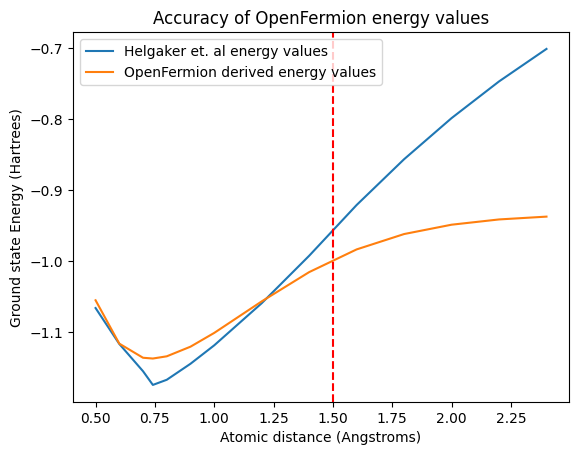

In [13]:
#compare OF to published data

ref_R  = np.array([0.50, 0.60, 0.70, 0.7414, 0.80, 0.90, 1.00, 1.20,
                   1.40, 1.60, 1.80, 2.00, 2.20, 2.40])
ref_E  = np.array([-1.066108, -1.116712, -1.155192, -1.174476, -1.167220,
                   -1.144640, -1.118653, -1.059317, -0.992430, -0.920881,
                   -0.856343, -0.798421, -0.746701, -0.700873]) #published gronud state energy values

of_energies = []
for bondlen in ref_R:
    en, ham = build_Hamiltonian(bondlen)
    of_energies.append(en)

plt.plot(ref_R, ref_E, label = "Helgaker et. al energy values")
plt.plot(ref_R, of_energies, label = "OpenFermion derived energy values")
plt.title("Accuracy of OpenFermion energy values")
#plt.scatter(bond_lengths, vqe_en, color='red', label = "depth 3 Parametric VQE energy calculation")
plt.legend()
plt.xlabel('Atomic distance (Angstroms)')
plt.ylabel('Ground state Energy (Hartrees)')

true_en = np.asarray(ref_E)
vqe_en = np.asarray(of_energies)
mse = np.mean((true_en - vqe_en)**2)

plt.axvline(1.5, color="red", linestyle ="dashed")
print("Mean squared error: ", mse)

mse_half = np.mean((true_en[:9] - vqe_en[:9])**2)
print("Mean squared error not including terms > 1.5: ", mse_half)


### Parametric Ansatz

In [4]:
#Unoptimal parameteric ansatz, "naive" assumption
def parametric_ansatz(depth):
    p = Program()
    p+= X(0)
    p+= X(1)
    theta = p.declare("theta", "REAL", 4 * depth) #theta is a list of 4*depth parametric params
    idx = 0
    for d in range(depth):
        for q in range(4):
            p+= RY(theta[idx], q)
            idx+=1
        #entangle everything
        p += CNOT(0, 1)
        p += CNOT(1, 2)
        p += CNOT(2, 3) ## d
        p += CNOT(3, 0)
    return p ## adding readout/measurement bits to fix this
        

### Porting to QPU Measurement

In [5]:
def prep_measure_prog(qc, term: PauliTerm, depth, shots): #builds compiled measurement program for each Hamiltonian term
    p = parametric_ansatz(depth)
    ro = p.declare("ro", "BIT", 4)#declare readout bits to measure onto
    #need to convert the measurement of the Pauli X and Y terms to the Z basis 
    for b, op in term.operations_as_set(): #loop over ham. term and append gates if nessecary to allow us to measure in |0>,|1>
        if op == 'X':
            p+= H(b) #X to Z basis
        elif op == 'Y':
            p+= RX(-np.pi/2, b) #Y to Z basis
        
    for q in range(4): #measure each bit to readout bit
        p+= MEASURE(q, ro[q])
    
    p.wrap_in_numshots_loop(shots)
    return qc.compile(p) # compile once per hamiltonian term; returns

def pauli_term_exp(bitstrings, term:PauliTerm): #post-process Pauli bit strings for energy estimation
    if term.id() == 'I':#if identity op. expectation value is always 1
        return 1.0
    qubit_ops = list(term.operations_as_set()) #readable Pauli format
    idxs = [q for q, _ in qubit_ops]
    #just get eigenvalues for the specific Pauli measurement
    sub_bits = bitstrings[:, idxs]
    eig_vals = 1-2*sub_bits
    prod = np.prod(eig_vals, axis=1)
    return prod.mean()
        
    
    

### Parametric Sweep model

In [4]:
def coeff(term): # helper to get coeff. quickly
    return term.coefficient.real

# bucket Hamiltonian terms by a qubit-wise key
def basis_key(term, n_qubits=4):
    key = ['Z'] * n_qubits                 # default: Z on every qubit
    for q, op in term.operations_as_set(): # overwrite X or Y where present
        key[q] = op
    return ''.join(key) #returns basis key 

def basis_programs(key): # compile one circ. for each basis key (i.e. each ham term)
    p = param_ansatz.copy()
    ro = p.declare("ro", "BIT", 4)
    for q, op in enumerate(key): #loop over key and apply basis change as needed
        if op == 'X':
            p += H(q)
        elif op == 'Y':
            p += RX(-np.pi/2, q)
        # 'Z' → no rotation
    
    for q in range(4):
        p += MEASURE(q, ro[q])
    #print(shots)
    p.wrap_in_numshots_loop(shots)
    return qc.compile(p)

def batch_energy_eval(params_batch):
    K = params_batch.size
    energies = np.full(K, const_term)

    for k, vec in enumerate(params_batch): #loop over each paramter vector and run a qpu job
        mem = {"theta": vec.astype(float)}
        E = const_term
        for key, prog in compiled_prog.items():
            bits = qc.run(prog, memory_map=mem).readout_data["ro"]
            bits = bits.reshape(shots, 4)
            eig  = 1 - 2*bits

            for term in basis_groups[key]:
                qs = [q for q, _ in term.operations_as_set()]
                prod = np.prod(eig[:, qs], axis=-1).mean()
                E+= term.coefficient.real * prod
        energies[k] = E

    return energies
    

### UCCSD Ansatz

In [87]:
def uccsd_param_ansatz(qubit_arr): #0,1,2,3 are naive qubit usages - 74-77 seem like good ones?
    
    term_1 = PauliTerm("Y", qubit_arr[0]) * PauliTerm("X", qubit_arr[1]) * PauliTerm("X", qubit_arr[2]) * PauliTerm("Y", qubit_arr[3]) #separate so not pauli sum objects
    term_2 = PauliTerm("X", qubit_arr[0]) * PauliTerm("Y", qubit_arr[1]) * PauliTerm("Y", qubit_arr[2]) * PauliTerm("X", qubit_arr[3])
    evo_A = exponential_map(term_1)     
    evo_B = exponential_map(term_2)

    p = Program()
    theta = p.declare("theta", "REAL")    # just one scalar parameter

    # Hartree-Fock prep |1100>
    p += X(qubit_arr[0])
    p += X(qubit_arr[1])

    # e^{-i θ (A−B)/2}  =  e^{-i(θ/2)A}  *  e^{+i(θ/2)B}
    p += evo_A( -0.5 * theta )       # minus sign for −i θ/2 A
    p += evo_B( +0.5 * theta )       # +i θ/2 B   (because −B)
    print(p)
    return p

# def uccsd_param_ansatz(): #0,1,2,3 are naive qubit usages - 74-77 seem like good ones?
    
#     term_1 = PauliTerm("Y", 0) * PauliTerm("X", 1) * PauliTerm("X", 2) * PauliTerm("Y", 3) #separate so not pauli sum objects
#     term_2 = PauliTerm("X", 0) * PauliTerm("Y", 1) * PauliTerm("Y", 2) * PauliTerm("X", 3)
#     evo_A = exponential_map(term_1)     
#     evo_B = exponential_map(term_2)

#     p = Program()
#     theta = p.declare("theta", "REAL")    # just one scalar parameter

#     # Hartree-Fock prep |1100>
#     p += X(0)
#     p += X(1)

#     # e^{-i θ (A−B)/2}  =  e^{-i(θ/2)A}  *  e^{+i(θ/2)B}
#     p += evo_A( -0.5 * theta )       # minus sign for −i θ/2 A
#     p += evo_B( +0.5 * theta )       # +i θ/2 B   (because −B)

#     return p

In [ ]:
%%time
from tqdm import tqdm 

depth = 3
num_params = 4*depth
#num_points = 1500
shots = 100
batch_size = 25
basis_groups = {}
#opt_qubits = [0,1,2,3] 
opt_qubits = [0,1,7,8]
bondlen = .75

#qc = get_qc("4q-qvm")
quantum_processor_id = select_available_qpu()
qc = get_qc(quantum_processor_id)#,  endpoint_id="BF16")

#using uccsd ansatz

param_ansatz = uccsd_param_ansatz(opt_qubits)
#param_ansatz = uccsd_param_ansatz()
num_params = 1
theta_grid = np.linspace(0.0, np.pi, 31)   # 31 evenly spaced points
param_grid = theta_grid.reshape(-1, 1)     # shape (31, 1)

#using old ansatz

#param_ansatz = parametric_ansatz(depth)
#param_grid = np.random.uniform(0, 2*np.pi, size=(num_points, num_params))

ground_energy, Ham = build_Hamiltonian(bondlen)
print(Ham)

# split Hamiltonian terms by basis; we'll compile one circuit for each Hamiltonian term
const_term = 0.0

for t in Ham.terms:
    if t.operations_as_set() == set(): # identity term, if so append coefficient 
        const_term += t.coefficient.real
    else:
        k = basis_key(t) #otherwise we need to get basis
        basis_groups.setdefault(k, []).append(t)

#print("Measurement bases :", list(basis_groups.keys()))

compiled_prog = {k: basis_programs(k) for k in basis_groups} #compile the circuit for each ham term

results = []
#exeucte grid scan
#print(param_grid.size)
print(f"Evaluating {param_grid.size} parameter points …")

for k in tqdm(range(0, param_grid.size, batch_size)): #tqdm package gives us the sexy lil bar
    batch = param_grid[k:k+batch_size]
    results.extend(batch_energy_eval(batch)) #append batch of results to energy result array
#print(type(results))
results = np.asarray(results)
idx_min = np.argmin(results)
best_E  = results[idx_min]
best_pars = param_grid[idx_min]
error_sq = (best_E - ground_energy)**2

print("\n================  GRID-SCAN RESULT  ================")
print(f"Exact FCI energy      : {ground_energy: .6f}  Ha")
print(f"Lowest scanned energy : {best_E: .6f}  Ha")
print(f"Parameter vector (rad): {best_pars}")
print(f" Squared error: {error_sq}" )

### Looping code for experiments

In [13]:

energies_arr = []

In [ ]:
%%time
#from tqdm import tqdm 

depth = 3
#num_points = 1500
num_params = 1
#shots = 100
opt_qubits = [0,1,7,8]
#opt_qubits = [0,1,2,3]
shots=1
batch_size = 25
basis_groups = {} 

#qc = get_qc("4q-qvm")
quantum_processor_id = select_available_qpu()
qc = get_qc(quantum_processor_id)

bond_lengths = np.linspace(.1,1.5,20)
true_en = []
vqe_en = []

for bond_len in bond_lengths:
    const_term = 0.0
    basis_groups = {}
    results = []
    param_ansatz = uccsd_param_ansatz(opt_qubits)
    theta_grid = np.linspace(0.0, np.pi, 31)   # 31 evenly spaced points
    param_grid = theta_grid.reshape(-1, 1)     # shape (31, 1)
    ground_energy, Ham = build_Hamiltonian(bond_len)
    
    for t in Ham.terms:
        if t.operations_as_set() == set(): # identity term, if so append coefficient 
            const_term += t.coefficient.real
        else:
            k = basis_key(t) #otherwise we need to get basis
            basis_groups.setdefault(k, []).append(t)
    
    compiled_prog = {k: basis_programs(k) for k in basis_groups} #compile the circuit for each ham term
    #print(param_grid)
    for k in range(0, theta_grid.size, batch_size):
        batch = param_grid[k:k+batch_size]
        results.extend(batch_energy_eval(batch)) #append batch of results to energy result array

    results = np.asarray(results)
    idx_min = np.argmin(results)
    best_E  = results[idx_min]
    #print(best_E)
    best_pars = param_grid[idx_min]
    vqe_en.append(best_E)
    true_en.append(ground_energy)
    



[2.5597171341954867, 0.457496730462978, -0.36536620663959873, -0.8435622937313725, -1.0578295615437172, -1.0943752642795361, -1.2452649220827, -1.2803712423950484, -1.2061651647789076, -1.2976198690792087, -1.2917337621336331, -1.2806671188694685, -1.2662871363972346, -1.149554556102608, -1.2320293499062465, -1.2135667807571862, -1.19486462027309, -1.1762712523105092, -1.158053180337734, -1.1404094906540883]
Mean squared error:  0.019425537754578066


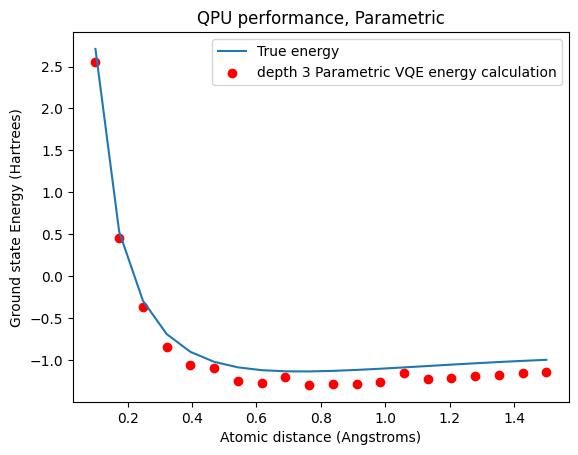

In [29]:
print(vqe_en)
plt.plot(bond_lengths, true_en, label = "True energy")
plt.title("QPU performance, Parametric")
plt.scatter(bond_lengths, vqe_en, color='red', label = "depth 3 Parametric VQE energy calculation")
plt.legend()
plt.xlabel('Atomic distance (Angstroms)')
plt.ylabel('Ground state Energy (Hartrees)')

true_en = np.asarray(true_en)
vqe_en = np.asarray(vqe_en)
mse = np.mean((true_en - vqe_en)**2)
print("Mean squared error: ", mse)

bond_lengths : (20,)
mean         : (20,)
yerr         : (2, 20)


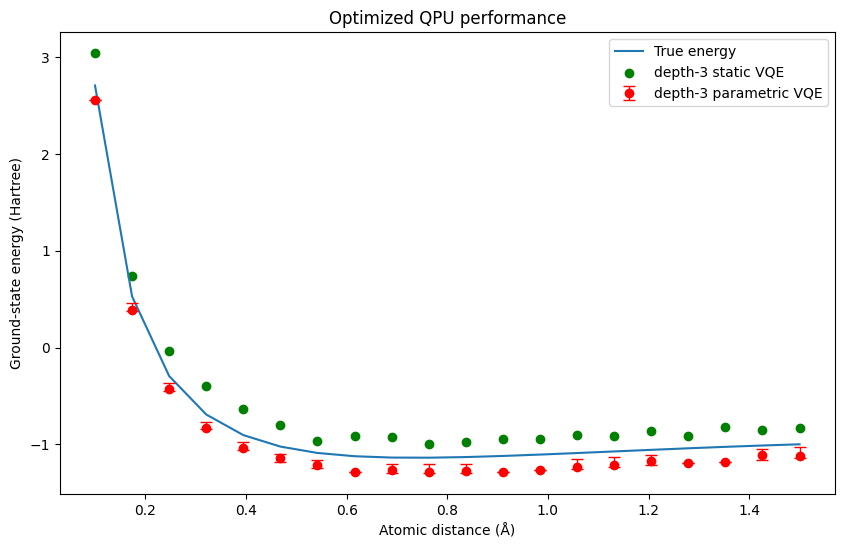

In [12]:
#experimentally determined energies
static_en = [3.0426272385549535, 0.7413488847950207, -0.03176065850506931, -0.39912034366981386, -0.631298889317559, -0.7961197262696144, -0.9600629367329242, -0.9147812894626836, -0.9266339091941042, -0.9976530689995017, -0.9715147922921454, -0.9481336640456737, -0.9468706009006786, -0.9044702914780562, -0.9074152323672486, -0.8564865338643283, -0.9093588025021546, -0.817937847519441, -0.8466755790838889, -0.826225741959399]
energies_arr = [[ 2.55971713,  0.37880164, -0.44496711, -0.84356229, -1.05782956,
       -1.17809241, -1.24526492, -1.28037124, -1.20616516, -1.20636241,
       -1.29173376, -1.28066712, -1.26628714, -1.24980097, -1.23202935,
       -1.10849703, -1.19486462, -1.17627125, -1.15805318, -1.14040949],[ 2.55971713,  0.37880164, -0.44496711, -0.84356229, -1.05782956,
       -1.17809241, -1.24526492, -1.28037124, -1.29537935, -1.29761987,
       -1.19834277, -1.28066712, -1.26628714, -1.24980097, -1.23202935,
       -1.21356678, -1.19486462, -1.17627125, -1.04567936, -1.14040949],[ 2.55971713,  0.37880164, -0.44496711, -0.76279585, -0.97567812,
       -1.17809241, -1.15983398, -1.28037124, -1.29537935, -1.29761987,
       -1.29173376, -1.28066712, -1.26628714, -1.24980097, -1.23202935,
       -1.10849703, -1.19486462, -1.17627125, -1.04567936, -1.14040949],[ 2.55971713,  0.37880164, -0.44496711, -0.84356229, -1.05782956,
       -1.09437526, -1.15983398, -1.28037124, -1.29537935, -1.29761987,
       -1.29173376, -1.28066712, -1.26628714, -1.24980097, -1.12938652,
       -1.21356678, -1.19486462, -1.17627125, -1.15805318, -1.02564152],[ 2.55971713,  0.45749673, -0.36536621, -0.84356229, -1.05782956,
       -1.09437526, -1.24526492, -1.28037124, -1.20616516, -1.29761987,
       -1.29173376, -1.28066712, -1.26628714, -1.14955456, -1.23202935,
       -1.21356678, -1.19486462, -1.17627125, -1.15805318, -1.14040949]]

bond_lengths = np.linspace(.1,1.5,20)

E = np.vstack(energies_arr)            # (n_runs, n_bond_lengths)
mean = E.mean(axis=0)                  # (N,)
lower = mean - E.min(axis=0)           # (N,)   positive!
upper = E.max(axis=0) - mean           # (N,)   positive!

yerr = np.abs(np.vstack([lower, upper]))       # shape (2, N)

print('bond_lengths :', np.shape(bond_lengths))
print('mean         :', mean.shape)
print('yerr         :', yerr.shape)    # should read (2, N)

# ----------------------------------------------------------------------
# 1) plot
# ----------------------------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(bond_lengths, true_en, label='True energy')
plt.scatter(bond_lengths, static_en, label = 'depth-3 static VQE', color = "green")

plt.errorbar(bond_lengths, mean,
             yerr=yerr,
             fmt='o',                  # marker (red circle)
             color='red',
             ecolor='red',
             capsize=4,
             elinewidth=1,
             label='depth-3 parametric VQE')

plt.title('Optimized QPU performance')
plt.xlabel('Atomic distance (Å)')
plt.ylabel('Ground-state energy (Hartree)')
plt.legend()
#plt.tight_layout()
plt.show()

In [19]:
mse = np.mean((true_en - mean)**2)
print("Mean squared error for parametric: ", mse)


mse2 = np.mean((true_en - np.asarray(static_en))**2)
print("Mean squared error for static: ", mse2)

Mean squared error for parametric:  0.01930338830426625
Mean squared error for static:  0.042561383150814126
[ 2.55971713  0.39454066 -0.42904693 -0.827409   -1.04139927 -1.14460555
 -1.21109254 -1.28037124 -1.25969367 -1.27936838 -1.27305556 -1.28066712
 -1.26628714 -1.22975169 -1.21150078 -1.17153888 -1.19486462 -1.17627125
 -1.11310365 -1.1174559 ]


In [20]:
mse = np.mean((true_en[1:] - mean[1:])**2)
print("Mean squared error for parametric (w/o first point): ", mse)


mse2 = np.mean((true_en[1:] - np.asarray(static_en)[1:])**2)
print("Mean squared error for static (w/o first point): ", mse2)

Mean squared error for parametric (w/o first point):  0.019131295498119424
Mean squared error for static (w/o first point):  0.03897687812065726


In [21]:
print(bond_lengths)

[0.1        0.17368421 0.24736842 0.32105263 0.39473684 0.46842105
 0.54210526 0.61578947 0.68947368 0.76315789 0.83684211 0.91052632
 0.98421053 1.05789474 1.13157895 1.20526316 1.27894737 1.35263158
 1.42631579 1.5       ]


### Parameter points @ .75 bond_len

Text(0.5, 1.0, 'θ points vs. MSE')

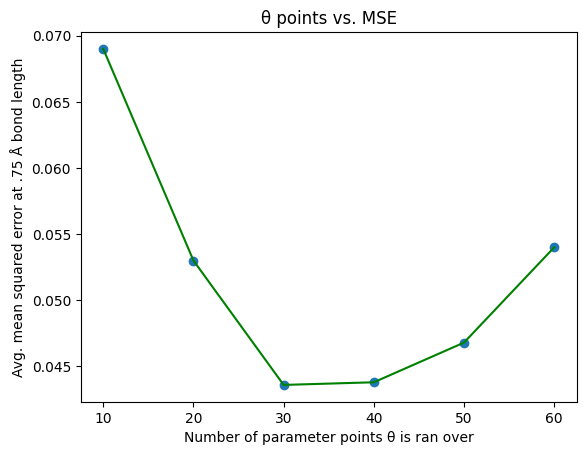

In [77]:
mse_avg_arr = [.069,.053,.0436,.0438,.0468, .054]
qpu_avg_arr = [1.99, 2.86, 3.91, 4.93, 5.92, 6.83]
point_arr = [10,20,30,40,50,60]
plt.scatter(point_arr, mse_avg_arr)
plt.plot(point_arr, mse_avg_arr, color = "green")
plt.xlabel("Number of parameter points θ is ran over" )
plt.ylabel("Avg. mean squared error at .75 Å bond length")
plt.title("θ points vs. MSE")

Text(0.5, 1.0, 'θ points vs. QPU time (s)')

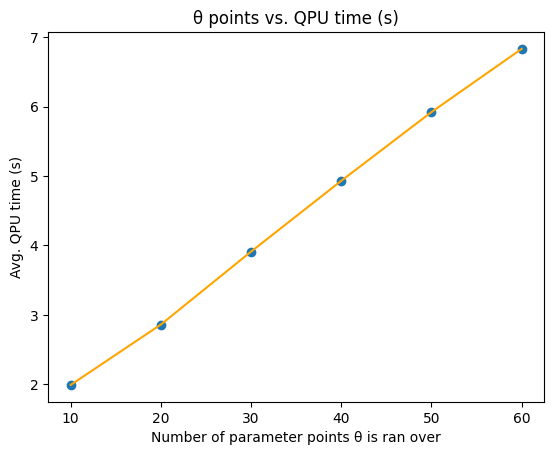

In [80]:
plt.scatter(point_arr, qpu_avg_arr)
plt.plot(point_arr, qpu_avg_arr, color = "orange")
plt.xlabel("Number of parameter points θ is ran over" )
plt.ylabel("Avg. QPU time (s)")
plt.title("θ points vs. QPU time (s)")